In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
# r2
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Importando modelos de machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [2]:
# Importando base de dados que contem o header
base = pd.read_csv('/home/apo-pc/Documents/GitHub/Classificacao_MHI_BIC/Codigos-Desenvolvimento/Datasets/df_soc_whoqol_reg.csv')
# Dividindo entre X e y, pelo tamanho da base
X = base.drop('Nivel_MHI', axis=1)
X = X.drop('MHI_Score', axis=1)
y = base['MHI_Score'].apply(lambda x: x/100)

df_Niveis = base['Nivel_MHI']

In [3]:
y.describe()

count    872.000000
mean       1.385585
std        0.335148
min        0.470000
25%        1.170000
50%        1.390000
75%        1.640000
max        2.240000
Name: MHI_Score, dtype: float64

In [4]:
# Dividindo a base entre treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
# Linear Regression
from sklearn.linear_model import LinearRegression
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
import math
import time

def test_and_tune_regression_models(x_train, y_train, x_test, y_test, filename='regression_results.csv'):
  """
  Tests various regression models, displays results, performs Random Search
  for hyperparameter tuning, and presents the tuned results.

  Args:
      x_train (pandas.DataFrame): Training data features.
      y_train (pandas.Series): Training data target variable.
      x_test (pandas.DataFrame): Testing data features.
      y_test (pandas.Series): Testing data target variable.
      filename (str): Name of the CSV file to save results to.

  Returns:
      None
  
  Outputs:
      CSV file: A CSV file containing the results of the regression models.
  """

  # Define models and their parameter grids for random search
  models = {
      'Linear Regression': {
          'model': LinearRegression(),
          'param_grid': {}  # Linear Regression has no hyperparameters to tune
      },
      'Decision Tree': {
          'model': DecisionTreeRegressor(),
          'param_grid': {
            #   'max_depth': range(2, 10),
            #   'min_samples_split': range(2, 20),
            #   'min_samples_leaf': range(1, 10)
                'criterion': ['absolute_error', 'squared_error', 'friedman_mse', 'poisson'],
                'splitter': ['best', 'random'],
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int)),
                'min_samples_split': np.linspace(0.01, 1, 20),
                'min_samples_leaf': np.linspace(0.01, 0.5, 20)
          }
      },
      'Random Forest': {
          'model': RandomForestRegressor(n_jobs=-1),
          'param_grid': {
            #   'n_estimators': range(100, 1000, 100),
            #   'max_depth': range(2, 10),
            #   'min_samples_split': range(2, 20),
            #   'min_samples_leaf': range(1, 10)
                # Vetor linear inteiro, entre log2(numero_de_classes) e numero_de_features/2
                'max_depth': np.unique(np.linspace(math.log2(len(np.unique(y))), len(X.columns) // 2, 20, dtype=int)),
                # Vetor linear inteiro, de ln(numero de objetos no conjunto) -40 até ln(numero de objetos no conjunto) + 45
                'n_estimators': np.unique(np.maximum(np.linspace(math.log(len(X)) - 40, math.log(len(X)) + 45, 20, dtype=int),1)),
                # Vetor linear inteiro, numero features * 0.3 até numero features * 0.8
                'max_features': np.unique(np.linspace(int(len(X.columns) * 0.3), int(len(X.columns) * 0.8), 20, dtype=int)),
                'criterion': ['absolute_error', 'squared_error', 'friedman_mse', 'poisson'],
                'bootstrap': [True, False]
          }
      },
      'XGBoost': {
          'model': XGBRegressor(n_jobs=-1),
          'param_grid': {
              'n_estimators': range(100, 1000, 100),
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': range(2, 10),
              'min_child_weight': range(1, 10),
              'gamma': [0, 0.1, 1]
          }
      },
      'K-Nearest Neighbors': {
          'model': KNeighborsRegressor(n_jobs=-1),
          'param_grid': {
                'n_neighbors': np.linspace(1, 30, 15, dtype=int),
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'p': [1, 2, 3, 4],
                'leaf_size': np.linspace(1, 100, 20, dtype=int)
          }
      },
      'Multi-Layer Perceptron (Neural Network)': {
          'model': MLPRegressor(),
          'param_grid': {
            #   'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
                'activation': ['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'],
                'hidden_layer_sizes': [(neurons,) * layers for layers in range(1, 4) for neurons in range(len(X.columns) * 5, len(X.columns) * 10 + 1)],
                'learning_rate_init': np.linspace(0.0001, 1, 10),
                'momentum': np.linspace(0.1, 0.9, 10),
                'max_iter': np.linspace(400, 4000, 20, dtype=int)
          }
      },
      'Support Vector Regression (SVR)': {
          'model': SVR(),
          'param_grid': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [0.00001, 0.0001, 0.001,  0.01, 0.1, 1, 10, 100, 1000, 10000],
            # 'degree': [3, 5, 8],
            'coef0': [0.01, 10, 0.5],
            'gamma': ['auto', 'scale']
            }
      }

}

  # Prepare empty DataFrame to store results
  results = pd.DataFrame(columns=['Modelo', 'Pre-Tuning MSE', 'Pre-Tuning RMSE', 'Pre-Tuning R2', 'Pre-Tuning R2 Ajustado', 'Pos-Tuning MSE', 'Pos-Tuning RMSE', 'Pos-Tuning R2', 'Pos-Tuning R2 Ajustado', 'Parametros'])

  # Test each model, store results, and print
  for model_name, model_info in models.items():
    model = model_info['model']
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Update results DataFrame
    results = pd.concat([results, pd.DataFrame({
        'Modelo': [model_name],
        'Pre-Tuning MSE': [mse],
        'Pre-Tuning RMSE': [rmse],
        'Pre-Tuning R2': [r2],
        'Pre-Tuning R2 Ajustado': [1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(X.columns) - 1)], # Adjusted R2 = 1 - (1 - R2) * (n - 1) / (n - p - 1)
        'Pos-Tuning MSE': [None],
        'Pos-Tuning RMSE': [None],
        'Pos-Tuning R2': [None],
        'Pos-Tuning R2 Ajustado': [None],
        'Parametros': [None]
    })], ignore_index=True)

    print(f"\n\n**{model_name} Resultados (Antes do Tuning):**")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"R2 Ajustado: {1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(X.columns) - 1):.4f}")

    print(f'\n_Realizando Tuning do Modelo: {model_name}_')
    agora = time.time()
    param_grid = model_info['param_grid']
    random_search = RandomizedSearchCV(model, param_grid, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    if model_name == 'Support Vector Regression (SVR)': # Use only a subset of the data for SVR to speed up tuning
        print("Usando subset")
        x_train_subset, _, y_train_subset, _ = train_test_split(x_train, y_train, train_size=0.5, shuffle=True)
        random_search.fit(x_train_subset, y_train_subset)
    else:
        random_search.fit(x_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    r2_ajustado = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(X.columns) - 1)
    depois = time.time()

    print(f"Tempo de execução: {depois - agora:.2f} segundos.")

    # Update results DataFrame
    results.loc[results['Modelo'] == model_name, 'Pos-Tuning MSE'] = mse
    results.loc[results['Modelo'] == model_name, 'Pos-Tuning RMSE'] = rmse
    results.loc[results['Modelo'] == model_name, 'Pos-Tuning R2'] = r2
    results.loc[results['Modelo'] == model_name, 'Pos-Tuning R2 Ajustado'] = r2_ajustado
    results.loc[results['Modelo'] == model_name, 'Parametros'] = random_search.best_params_

    print(f"**{model_name} Resultados (Depois do Tuning):**")
    print(f"Melhores Parametros: {random_search.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"R2 Ajustado: {r2_ajustado:.4f}")

  # Save results to CSV file
  results.to_csv(filename, index=False)

  print(f"\nResultados salvos em: '{filename}'.")

In [35]:
test_and_tune_regression_models(X_train, y_train, X_test, y_test)



**Linear Regression Resultados (Antes do Tuning):**
MSE: 0.0400
RMSE: 0.1999
R2: 0.6390
R2 Ajustado: 0.3020

_Realizando Tuning do Modelo: Linear Regression_
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Tempo de execução: 0.95 segundos.
**Linear Regression Resultados (Depois do Tuning):**
Melhores Parametros: {}
MSE: 0.0400
RMSE: 0.1999
R2: 0.6390
R2 Ajustado: 0.3020


**Decision Tree Resultados (Antes do Tuning):**
MSE: 0.0678
RMSE: 0.2603
R2: 0.3875
R2 Ajustado: -0.1841

_Realizando Tuning do Modelo: Decision Tree_
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 1.03 segundos.
**Decision Tree Resultados (Depois do Tuning):**
Melhores Parametros: {'splitter': 'random', 'min_samples_split': 0.06210526315789474, 'min_samples_leaf': 0.01, 'max_depth': 25, 'criterion': 'friedman_mse'}
MSE: 0.0439
RMSE: 0.2096
R2: 0.6030
R2 Ajustado: 0.2324


**Random Forest Resultados (Antes do Tuning):**
MSE: 0.0385
RMSE: 0.1962
R2: 0.6523
R2 Ajustado: 0.

/home/apo-pc/anaconda3/envs/bic/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/home/apo-pc/anaconda3/envs/bic/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/apo-pc/anaconda3/envs/bic/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/apo-pc/anaconda3/envs/bic/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/apo-pc/anaconda3/envs/bic/lib/python3.11/site-packages/sklearn/utils/extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/apo-pc/anaconda3/envs/bic/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/h

Tempo de execução: 7969.52 segundos.
**Multi-Layer Perceptron (Neural Network) Resultados (Depois do Tuning):**
Melhores Parametros: {'solver': 'lbfgs', 'momentum': 0.1, 'max_iter': 1347, 'learning_rate_init': 0.6667000000000001, 'hidden_layer_sizes': (625,), 'activation': 'identity'}
MSE: 0.0397
RMSE: 0.1993
R2: 0.6410
R2 Ajustado: 0.3059


**Support Vector Regression (SVR) Resultados (Antes do Tuning):**
MSE: 0.0374
RMSE: 0.1935
R2: 0.6618
R2 Ajustado: 0.3462

_Realizando Tuning do Modelo: Support Vector Regression (SVR)_
Usando subset
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tempo de execução: 2031.04 segundos.
**Support Vector Regression (SVR) Resultados (Depois do Tuning):**
Melhores Parametros: {'kernel': 'rbf', 'gamma': 'scale', 'coef0': 10, 'C': 1}
MSE: 0.0405
RMSE: 0.2012
R2: 0.6343
R2 Ajustado: 0.2929

Resultados salvos em: 'regression_results.csv'.


In [6]:
import multiprocessing
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import os
# Função para aplicar SBFS e SFFS com cross validation e salvar tabela com resultado.
def perform_feature_selection(data, target, model, best_model, method, cv):
    n_cpus = multiprocessing.cpu_count()
    # Criando o objeto de seleção de features
    if method == 'SBFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=False,
                  floating=True,
                  verbose=2,
                  scoring='neg_mean_squared_error',
                  cv=cv,
                  n_jobs=n_cpus)
    elif method == 'SFFS':
        sfs = SFS(model,
                  k_features="best",
                  forward=True,
                  floating=True,
                  verbose=2,
                  scoring='neg_mean_squared_error',
                  cv=cv,
                  n_jobs=n_cpus)
    # Aplicando o método de seleção de features
    sfs = sfs.fit(data, target)
    # Salvando o resultado em um dataframe
    df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Definindo nome do arquivo para salvar as features selecionadas em formato CSV
    if os.path.exists(f"results/{method}_{best_model}.csv"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.csv"):
            i += 1
        file_name_csv = f"results/{method}_{best_model}_{i}.csv"
    else:
        file_name_csv = f"results/{method}_{best_model}.csv"

    # Salvando o dataframe em um arquivo CSV
    df.to_csv(file_name_csv, index=False)

    # Definindo nome do arquivo para salvar as features selecionadas em formato TXT
    if os.path.exists(f"results/{method}_{best_model}.txt"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.txt"):
            i += 1
        file_name_txt = f"results/{method}_{best_model}_{i}.txt"
    else:
        file_name_txt = f"results/{method}_{best_model}.txt"

    # Salvando as features selecionadas e o score em um arquivo TXT
    with open(file_name_txt, 'w') as file:
        file.write(f"Selected Features: {', '.join(sfs.k_feature_names_)}\n")
        file.write(f"Score: {sfs.k_score_}")

    # Plotando o desempenho do modelo para cada combinação de atributos
    fig, ax = plt.subplots()
    ax.plot(range(1, len(df) + 1), df['avg_score'], marker='o')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Average Score')
    ax.set_title('Performance of Model with Feature Selection')
    plt.xticks(range(1, len(df) + 1))
    plt.grid(True)

    # Definindo nome do arquivo para salvar o gráfico
    if os.path.exists(f"results/{method}_{best_model}.png"):
        i = 1
        while os.path.exists(f"results/{method}_{best_model}_{i}.png"):
            i += 1
        file_name_plot = f"results/{method}_{best_model}_{i}.png"
    else:
        file_name_plot = f"results/{method}_{best_model}.png"

    # Salvando o gráfico em um arquivo PNG
    plt.savefig(file_name_plot)

    # Retornando as features selecionadas e o score
    return sfs.k_feature_names_, sfs.k_score_

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:    3.5s finished

[2024-04-01 19:04:25] Features: 1/84 -- score: -0.041943899457483384[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:    2.7s finished

[2024-04-01 19:04:28] Features: 2/84 -- score: -0.03907290008505614[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:    2.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished

[2024-04-01 19:04:32] Features: 3/84 -- score: -0.036071807939834444[Parallel(n_jobs=16

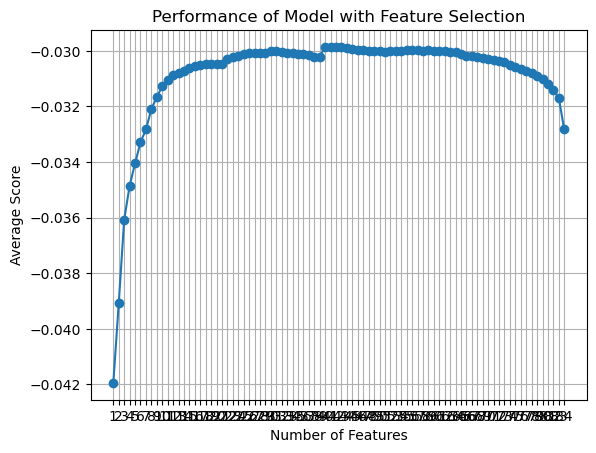

In [18]:
# Best Model: XGBoost
# {'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0}
# Definindo o modelo de regressão
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# model = XGBRegressor(n_estimators=600, min_child_weight=3, max_depth=3, learning_rate=0.01, gamma=0, n_jobs=-1)
model = SVR(C=0.001, coef0=10, gamma='auto', kernel='linear')


# Aplicando o método de seleção de features
features, score = perform_feature_selection(X_train, y_train, model, 'SVR_TrueBest', 'SFFS', 5)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=16)]: Done  84 out of  84 | elapsed:   17.6s finished

[2024-04-02 07:41:32] Features: 83/1 -- score: -0.03169706144926351[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done  83 out of  83 | elapsed:   16.4s finished

[2024-04-02 07:41:48] Features: 82/1 -- score: -0.031407140266621066[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done  82 out of  82 | elapsed:   16.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.4s finished

[2024-04-02 07:42:06] Features: 81/1 -- score: -0.031186392656379104[Parallel(n_jobs=16

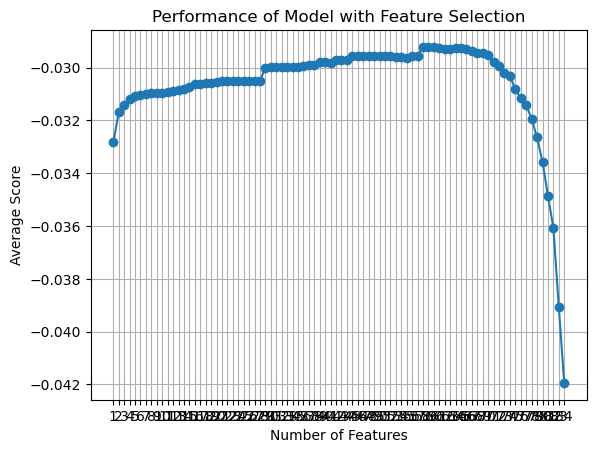

In [19]:
features_sbfs, score_sbfs = perform_feature_selection(X_train, y_train, model, 'SVR_TrueBest', 'SBFS', 5)

In [7]:
# Função para pegar as features selecionadas do csv. Essa função retorna uma lista com as features selecionadas.
def get_features_selected(file):
    df = pd.read_csv(file)
    # Seleciona a linha da coluna avg_score que possui o maior valor
    df = df.loc[df['avg_score'] == df['avg_score'].max()]
    
    # Agora pega as features na coluna feature_idx
    features = df['feature_idx'].values[0]
    
    # Transforma a string em lista
    features = features.replace(' ', '').replace('(', '').replace(')', '').split(',')
    
    # Transforma os elementos da lista em inteiros
    features = [int(i) for i in features]
    
    return features

### Resultados Com Seleção de Atributos

#### Numero de Features

In [10]:
# Pegando as features selecionadas
features = get_features_selected('results/SFFS_XBGRegressor.csv')
features_sbfs = get_features_selected('results/SBFS_XBGRegressor.csv')

model = XGBRegressor(n_estimators=600, min_child_weight=3, max_depth=3, learning_rate=0.01, gamma=0, n_jobs=-1)

print("SFFS")
print(f"Qtd de Features Selecionadas: {len(features)}")
print(f"Features Selecionadas: {features}")

print("\nSBFS")
print(f"Qtd de Features Selecionadas: {len(features_sbfs)}")
print(f"Features Selecionadas (SBFS): {features_sbfs}")


SFFS
Qtd de Features Selecionadas: 25
Features Selecionadas: [2, 8, 9, 13, 16, 17, 23, 30, 40, 41, 46, 48, 50, 51, 57, 64, 66, 71, 75, 77, 79, 80, 81, 82, 83]

SBFS
Qtd de Features Selecionadas: 22
Features Selecionadas (SBFS): [3, 9, 13, 16, 23, 33, 37, 39, 40, 51, 57, 62, 63, 64, 66, 69, 71, 72, 77, 79, 81, 82]


#### SBFS

In [11]:
from sklearn.model_selection import KFold

# Initialize KFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Seed for reproducibility

# Initialize lists to store results for each fold
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []
r2_adjusted_scores = []

# Iterate through each fold
for train_index, test_index in kf.split(X):
   X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
   y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

   # Get features selected for the current fold
   features_sbfs_fold = get_features_selected('results/SBFS_XGBRegressor.csv')

   # Fit the model with the selected features on the training fold
   model.fit(X_train_fold.iloc[:, features_sbfs_fold], y_train_fold)

   # Make predictions on the test fold
   y_pred_fold = model.predict(X_test_fold.iloc[:, features_sbfs_fold])

   # Calculate and store evaluation scores for this fold
   mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
   rmse_fold = np.sqrt(mse_fold)
   mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
   r2_fold = r2_score(y_test_fold, y_pred_fold)
   r2_adjusted_fold = 1 - (1 - r2_fold) * (len(y_test_fold) - 1) / (
       len(y_test_fold) - len(X.iloc[features_sbfs_fold].columns) - 1
   )

   mse_scores.append(mse_fold)
   rmse_scores.append(rmse_fold)
   mae_scores.append(mae_fold)
   r2_scores.append(r2_fold)
   r2_adjusted_scores.append(r2_adjusted_fold)

# Print the scores after cross-validation
print("Cross-Validation Results:")
print(f"Mean MSE: {np.mean(mse_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f}")
print(f"Mean R2: {np.mean(r2_scores):.4f}")
print(f"Mean Adjusted R2: {np.mean(r2_adjusted_scores):.4f}")


Cross-Validation Results:
Mean MSE: 0.0322
Mean RMSE: 0.1790
Mean MAE: 0.1409
Mean R2: 0.7128
Mean Adjusted R2: 0.4430


#### SFFS

In [12]:
from sklearn.model_selection import KFold

# Initialize KFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Seed for reproducibility

# Initialize lists to store results for each fold
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []
r2_adjusted_scores = []

# Iterate through each fold
for train_index, test_index in kf.split(X):
   X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
   y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

   # Get features selected for the current fold
   features_sbfs_fold = get_features_selected('results/SFFS_XGBRegressor.csv')

   # Fit the model with the selected features on the training fold
   model.fit(X_train_fold.iloc[:, features_sbfs_fold], y_train_fold)

   # Make predictions on the test fold
   y_pred_fold = model.predict(X_test_fold.iloc[:, features_sbfs_fold])

   # Calculate and store evaluation scores for this fold
   mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
   rmse_fold = np.sqrt(mse_fold)
   mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
   r2_fold = r2_score(y_test_fold, y_pred_fold)
   r2_adjusted_fold = 1 - (1 - r2_fold) * (len(y_test_fold) - 1) / (
       len(y_test_fold) - len(X.iloc[features_sbfs_fold].columns) - 1
   )

   mse_scores.append(mse_fold)
   rmse_scores.append(rmse_fold)
   mae_scores.append(mae_fold)
   r2_scores.append(r2_fold)
   r2_adjusted_scores.append(r2_adjusted_fold)

# Print the scores after cross-validation
print("Cross-Validation Results:")
print(f"Mean MSE: {np.mean(mse_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f}")
print(f"Mean R2: {np.mean(r2_scores):.4f}")
print(f"Mean Adjusted R2: {np.mean(r2_adjusted_scores):.4f}")


Cross-Validation Results:
Mean MSE: 0.0332
Mean RMSE: 0.1818
Mean MAE: 0.1436
Mean R2: 0.7035
Mean Adjusted R2: 0.4249


### KFold

In [8]:

# DecisionTree: 'splitter': 'best', 'min_samples_split': 0.16631578947368422, 'min_samples_leaf': 0.06157894736842105, 'max_depth': 12, 'criterion': 'absolute_error'
# RandomForest: {'n_estimators': 51, 'max_features': 27, 'max_depth': 20, 'criterion': 'absolute_error', 'bootstrap': False}
# XGBoost: {'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0}
# Knn: {'weights': 'distance', 'p': 1, 'n_neighbors': 11, 'leaf_size': 94, 'algorithm': 'brute'}
# MLP: {'solver': 'lbfgs', 'momentum': 0.8111111111111111, 'max_iter': 1347, 'learning_rate_init': 0.2223, 'hidden_layer_sizes': (754, 754, 754), 'activation': 'identity'}
# SVR: {'kernel': 'linear', 'gamma': 'auto', 'coef0': 10, 'C': 0.001}
models_pure = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor(), KNeighborsRegressor(), MLPRegressor(), SVR()]
models_parametros = [{'model': LinearRegression(), 'parametros': {}},
                      {'model': DecisionTreeRegressor(), 'parametros': {'splitter': 'best', 'min_samples_split': 0.16631578947368422, 'min_samples_leaf': 0.06157894736842105, 'max_depth': 12, 'criterion': 'absolute_error'}},
                      {'model': RandomForestRegressor(), 'parametros': {'n_estimators': 51, 'max_features': 27, 'max_depth': 20, 'criterion': 'absolute_error', 'bootstrap': False}},
                      {'model': XGBRegressor(), 'parametros': {'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0}},
                      {'model': KNeighborsRegressor(), 'parametros': {'weights': 'distance', 'p': 1, 'n_neighbors': 11, 'leaf_size': 94, 'algorithm': 'brute'}},
                      {'model': MLPRegressor(), 'parametros': {'solver': 'lbfgs', 'momentum': 0.8111111111111111, 'max_iter': 1347, 'learning_rate_init': 0.2223, 'hidden_layer_sizes': (754, 754, 754), 'activation': 'identity'}},
                      {'model': SVR(), 'parametros': {'kernel': 'linear', 'gamma': 'auto', 'coef0': 10, 'C': 0.001}}]


In [ ]:
for model in models_pure:
  # Initialize lists to store results for each fold
  mse_scores = []
  rmse_scores = []
  mae_scores = []
  r2_scores = []
  r2_adjusted_scores = []

  # Iterate through each fold
  for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Get features selected for the current fold
    features_sbfs_fold = get_features_selected('results/SFFS_XGBRegressor.csv')

    # Fit the model with the selected features on the training fold
    model.fit(X_train_fold.iloc[:, features_sbfs_fold], y_train_fold)

    # Make predictions on the test fold
    y_pred_fold = model.predict(X_test_fold.iloc[:, features_sbfs_fold])

    # Calculate and store evaluation scores for this fold
    mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
    rmse_fold = np.sqrt(mse_fold)
    mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
    r2_fold = r2_score(y_test_fold, y_pred_fold)
    r2_adjusted_fold = 1 - (1 - r2_fold) * (len(y_test_fold) - 1) / (
        len(y_test_fold) - len(X.iloc[features_sbfs_fold].columns) - 1
    )

    mse_scores.append(mse_fold)
    rmse_scores.append(rmse_fold)
    mae_scores.append(mae_fold)
    r2_scores.append(r2_fold)
    r2_adjusted_scores.append(r2_adjusted_fold)

  # Print the scores after cross-validation
  print("Cross-Validation Results:")
  print(f"Mean MSE: {np.mean(mse_scores):.4f}")
  print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
  print(f"Mean MAE: {np.mean(mae_scores):.4f}")
  print(f"Mean R2: {np.mean(r2_scores):.4f}")
  print(f"Mean Adjusted R2: {np.mean(r2_adjusted_scores):.4f}")


In [16]:

# Initialize lists to store results for each fold
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []
r2_adjusted_scores = []

# Iterate through each model
for model_info in models_parametros:
    model = model_info['model']
    parametros = model_info['parametros']
    model.set_params(**parametros)
    # Initialize lists to store results for each fold
    mse_scores = []
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    r2_adjusted_scores = []
    # Iterate through each fold
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        # Get features selected for the current fold
        features_sbfs_fold = get_features_selected('results/SFFS_XGBRegressor.csv')
        # Fit the model with the selected features on the training fold
        model.fit(X_train_fold.iloc[:, features_sbfs_fold], y_train_fold)
        # Make predictions on the test fold
        y_pred_fold = model.predict(X_test_fold.iloc[:, features_sbfs_fold])
        # Calculate and store evaluation scores for this fold
        mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
        rmse_fold = np.sqrt(mse_fold)
        mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
        r2_fold = r2_score(y_test_fold, y_pred_fold)
        r2_adjusted_fold = 1 - (1 - r2_fold) * (len(y_test_fold) - 1) / (
            len(y_test_fold) - len(X.iloc[features_sbfs_fold].columns) - 1
        )
        mse_scores.append(mse_fold)
        rmse_scores.append(rmse_fold)
        mae_scores.append(mae_fold)
        r2_scores.append(r2_fold)
        r2_adjusted_scores.append(r2_adjusted_fold)
    # Print the scores after cross-validation
    print(f"Modelo: {model}")
    print("Cross-Validation Results:")
    print(f"Mean MSE: {np.mean(mse_scores):.4f}")
    print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f}")
    print(f"Mean R2: {np.mean(r2_scores):.4f}")
    print(f"Mean Adjusted R2: {np.mean(r2_adjusted_scores):.4f}")
    print("\n\n")




Modelo: LinearRegression()
Cross-Validation Results:
Mean MSE: 0.0320
Mean RMSE: 0.1784
Mean MAE: 0.1383
Mean R2: 0.7139
Mean Adjusted R2: 0.4451



Modelo: DecisionTreeRegressor(criterion='absolute_error', max_depth=12,
                      min_samples_leaf=0.06157894736842105,
                      min_samples_split=0.16631578947368422)
Cross-Validation Results:
Mean MSE: 0.0489
Mean RMSE: 0.2206
Mean MAE: 0.1742
Mean R2: 0.5621
Mean Adjusted R2: 0.1505



Modelo: RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=20,
                      max_features=27, n_estimators=51)
Cross-Validation Results:
Mean MSE: 0.0392
Mean RMSE: 0.1975
Mean MAE: 0.1558
Mean R2: 0.6502
Mean Adjusted R2: 0.3215



Modelo: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,


### Analise importancia dos atributos

In [20]:
# Analisar o coenficente dos atributos usando Regressão Linear
from sklearn.linear_model import LinearRegression
# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Get the coefficients of the model
coefficients = model.coef_

# Get the names of the features
feature_names = X.columns

# Create a DataFrame with the coefficients and feature names
df_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame by values of the coefficients
df_coefficients = df_coefficients.sort_values(by='Coefficient', ascending=False)

# Display the DataFrame
print("Top 10 Atributos com Maior Coeficiente (Positivo)")
display(df_coefficients.head(10))

print("Top 10 Atributos com Menor Coeficiente (Negativo)")
display(df_coefficients.tail(10))


Top 10 Atributos com Maior Coeficiente (Positivo)


,Feature,Coefficient
83,CU,1.187754e+10
31,D_5.0,5.486741e+09
28,D_2.0,5.486741e+09
29,D_3.0,5.486741e+09
27,D_1.0,5.486741e+09
30,D_4.0,5.486741e+09
79,CQ,3.506344e+09
72,CJ,3.506344e+09
58,BV,3.506344e+09
59,BW,3.506344e+09


Top 10 Atributos com Menor Coeficiente (Negativo)


,Feature,Coefficient
66,CD,-1.484692e+09
76,CN,-1.484692e+09
77,CO,-1.484692e+09
43,J_4.0,-7.671418e+09
40,J_1.0,-7.671418e+09
44,J_5.0,-7.671418e+09
41,J_2.0,-7.671418e+09
42,J_3.0,-7.671418e+09
80,CR,-1.023224e+10
81,CS,-2.103806e+10
